In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci # High-contrast imaging observation class

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
def make_psf(f='F444W', m='MASK430R', p='CIRCLYOT', wfe_drift=0, roff=0):
#     f='F444W'; m='MASK430R'; p='CIRCLYOT'; wfe_drift=10; roff=2

    cf_psf = nrc_utils.psf_coeff(f, p, m, fov_pix=320, oversample=2, jitter='gaussian',
                                 wfe_drift=wfe_drift, offset_r=roff, offset_theta=90,
                                 quick=True, save=False)
    psf = nrc_utils.gen_image_coeff(f, p, m, coeff=cf_psf, fov_pix=320, oversample=2)
    
    #psf = nrc_utils.fshift(psf, delx=roff/nrc_utils.pixscale_LW, pad=True)
    
    return psf

In [4]:
dr = 0.025
roff = np.arange(0, 1.5+dr, dr)[::-1]

In [5]:
# Drifted reference PSFs
%time refarr = [make_psf(roff=r, wfe_drift=10) for r in roff]

CPU times: user 15min 6s, sys: 5min 40s, total: 20min 47s
Wall time: 32min 19s


In [6]:
# Create an NRC_HCI class to calculate planet PSFs
filt, mask, pupil = ('F444W',  'MASK430R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (320, 2)

obs = pynrc.nrc_hci(filter=filt, mask=mask, pupil=pupil, 
                    fov_pix=fov_pix, oversample=oversample, 
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize, verbose=True)

Generating background PSF coefficients...
Generating oversampled PSFs...


In [7]:
# Generate coronagraphic mask images (oversampled)
os_mask = 4
crop_pix = fov_pix * os_mask
pscale = obs.pixelscale / os_mask

carr = []
cmask = nrc_utils.coron_trans('MASK430R', pixscale=pscale)
for r in roff:
    rpix = r / pscale

    cmask2 = nrc_utils.fourier_imshift(cmask, rpix, 0, pad=True)
    cmask2 = nrc_utils.pad_or_cut_to_size(cmask2, (crop_pix,crop_pix))
    
    carr.append(cmask2)

In [8]:
# Create undrifted science PSFs
imarr = [make_psf(roff=r, wfe_drift=0) for r in roff]

In [9]:
# Add companions
loc_list = [(-np.sqrt(1),np.sqrt(1), 1e4), (np.sqrt(3),np.sqrt(3), 1e5)]

imarr2 = []
for i, r in enumerate(roff):
    imarr2.append(imarr[i] + 0.)
    for loc in loc_list:
        xoff_asec, yoff_asec, norm = loc # arcsec
        xoff_pix = (xoff_asec - r) / obs.pix_scale
        yoff_pix = yoff_asec / obs.pix_scale
        r_pl, th_pl = nrc_utils.xy_to_rtheta(xoff_asec, yoff_asec)
        im = obs.gen_offset_psf(r_pl, th_pl)
        
        imarr2[i] += nrc_utils.fourier_imshift(im, xoff_pix, yoff_pix, pad=True) / norm



In [10]:
diff = [imarr2[i] - refarr[i] for i in range(len(roff))]

In [11]:
im_max = np.max(imarr2[-1])

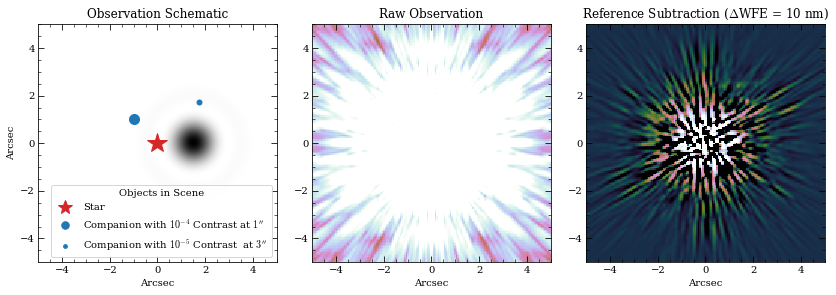

In [35]:
from matplotlib.colors import LogNorm, SymLogNorm

val = fov_pix/2
extent = np.array([-val, val, -val, val]) * obs.pixelscale
xylim = 5

i = 0

fig, axes = plt.subplots(1,3, figsize=(12,4.3))

# Axes titles
axes[0].set_title('Observation Schematic')
axes[1].set_title('Raw Observation')
axes[2].set_title('Reference Subtraction ($\Delta$WFE = 10 nm)')
# axes[2].set_title('Reference PSF Subtraction')

# Mask Location
im1 = axes[0].imshow(carr[i], extent=extent, interpolation='none', cmap='gray', vmin=0, vmax=1)
axes[0].plot([0],[0], marker='*', ms=20, color='C3', ls='none', label='Star')

loc = loc_list[0]
axes[0].plot([loc[0]],[loc[1]], marker='o', ms=10, color='C0', ls='none', 
             label='Companion with $10^{-4}$ Contrast at $1^{\prime\prime}$')
loc = loc_list[1]
axes[0].plot([loc[0]],[loc[1]], marker='o', ms=5, color='C0', ls='none', 
             label='Companion with $10^{-5}$ Contrast  at $3^{\prime\prime}$')

axes[0].legend(loc=4, markerscale=0.75, fontsize=10, title='Objects in Scene')

# Raw Observation
norm = SymLogNorm(linthresh=2e-8, linscale=1, vmin=-im_max/200, vmax=im_max/5)
# im = nrc_utils.fshift(imarr2[i], delx=roff[i]/obs.pixelscale, pad=True)
dx = roff[i]/obs.pixelscale
im = nrc_utils.fourier_imshift(imarr2[i], dx, 0, pad=True)
im2 = axes[1].imshow(im, norm=norm, extent=extent, interpolation='none', cmap='cubehelix')

# PSF Subtraction
# im = nrc_utils.fshift(diff[i], delx=roff[i]/obs.pixelscale, pad=True)
im = nrc_utils.fourier_imshift(diff[i], dx, 0, pad=True)
im3 = axes[2].imshow(im, norm=norm, extent=extent, interpolation='none', cmap='cubehelix')

for ax in axes:
    ax.set_xlim([-xylim,xylim])
    ax.set_ylim([-xylim,xylim])
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.set_xlabel('Arcsec')
axes[0].set_ylabel('Arcsec')
    
# for ax in axes[1:]:
#     ax.tick_params(axis='both', color='white', which='both')
#     for k in ax.spines.keys():
#         ax.spines[k].set_color('white')



fig.tight_layout()

In [13]:
def fig_update(i):
    im1 = axes[0].imshow(carr[i], extent=extent, interpolation='none', cmap='gray', vmin=0, vmax=1)
    axes[0].plot([0],[0], marker='*', ms=20, color='C3', ls='none', label='Star')

    # Raw Observation
    norm = SymLogNorm(linthresh=2e-8, linscale=1, vmin=-im_max/200, vmax=im_max/5)
    # norm = SymLogNorm(linthresh=5e-8, linscale=1, vmin=-im_max/100, vmax=im_max/5)
    # im = nrc_utils.fshift(imarr2[i], delx=roff[i]/obs.pixelscale, pad=True)
    dx = roff[i]/obs.pixelscale
    im = nrc_utils.fourier_imshift(imarr2[i], dx, 0, pad=True)
    im2 = axes[1].imshow(im, norm=norm, extent=extent, interpolation='none', cmap='cubehelix')

    # PSF Subtraction
    # im = nrc_utils.fshift(diff[i], delx=roff[i]/obs.pixelscale, pad=True)
    im = nrc_utils.fourier_imshift(diff[i], dx, 0, pad=True)
    im3 = axes[2].imshow(im, norm=norm, extent=extent, interpolation='none', cmap='cubehelix')

    
#     # Raw Observation
#     norm = SymLogNorm(linthresh=5e-8, linscale=1, vmin=-im_max/100, vmax=im_max/5)
#     im2 = axes[1].imshow(imarr[i], norm=norm, extent=extent, interpolation='none')
#     # PSF Subtraction
#     im3 = axes[2].imshow(diff[i], norm=norm, extent=extent, interpolation='none')

    return [im1, im2, im3]


In [23]:
# choose the interval based on dt and the time to animate one step
from time import time

fps = 20
dt = 1/fps

t0 = time()
fig_update(0)
t1 = time()

interval = np.int(1000 * dt - (t1 - t0) + 0.5)

In [37]:
ims = []

# res = fig_update(0)
# for i in np.arange(5):
#     ims.append(res)

for i in np.arange(len(roff)):
    res = fig_update(i)
    ims.append(res)
    
res = fig_update(-1)
for i in np.arange(8):
    ims.append(res)

for i in np.arange(len(roff)):
    res = fig_update(len(roff)-i-1)
    ims.append(res)


In [39]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [38]:
import matplotlib.animation as animation
# Animate a series of figure updates
%time ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True, repeat=True)

CPU times: user 10.5 s, sys: 1.68 s, total: 12.1 s
Wall time: 12.1 s


In [40]:
mywriter = animation.FFMpegWriter(bitrate=-1, fps=fps)
%time ani.save(mask+'_occult_movie.mp4', writer=mywriter)

CPU times: user 1min 33s, sys: 7.45 s, total: 1min 41s
Wall time: 1min 41s


In [41]:
%time ani.save(mask+'_occult_movie.gif', fps=fps, writer='imagemagick')

CPU times: user 1min 33s, sys: 7.55 s, total: 1min 40s
Wall time: 2min 8s


In [28]:
from IPython.display import HTML, Image
#Image(url=mask+'_occult_movie.gif')

In [42]:
ani2 = animation.FuncAnimation(fig, fig_update, frames=len(roff), interval=interval, blit=True, repeat=True)

In [43]:
mywriter = animation.FFMpegWriter(bitrate=-1, fps=fps)
%time ani2.save(mask+'_occult_movie2.mp4', writer=mywriter)

CPU times: user 6min 37s, sys: 1min, total: 7min 37s
Wall time: 7min 38s


In [29]:
%time ani2.save(mask+'_occult_movie2.gif', fps=fps, writer='imagemagick')

CPU times: user 7min 4s, sys: 1min 3s, total: 8min 8s
Wall time: 8min 23s
